In [ ]:
from tkinter import filedialog
from tkinter import Tk
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import seaborn as sns
import math
import os  # ファイル保存のために追加

# k-分割交差検証用のデータセットを準備
def prepare_kfold_data(df, target_var, feature_vars):
    X = df[feature_vars]
    y = df[target_var]
    return X, y

# モデル訓練とハイパーパラメータチューニング
def train_xgboost_optuna(X_train, y_train):
    def objective(trial):
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
        max_depth = trial.suggest_int('max_depth', 3, 5)
        
        model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, objective='reg:squarederror')
        return mean_squared_error(y_train, model.fit(X_train, y_train).predict(X_train))
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    
    best_params = study.best_params
    best_model = XGBRegressor(**best_params, objective='reg:squarederror')
    best_model.fit(X_train, y_train)
    
    y_train_pred = best_model.predict(X_train)
    return best_model, best_params, y_train_pred

# モデル評価
def evaluate_model(model, X_test, y_test, X_train, y_train):
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    rmse_test = math.sqrt(mean_squared_error(y_test, y_pred))
    r2_test = r2_score(y_test, y_pred)
    rmse_train = math.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    return rmse_test, r2_test, y_pred, rmse_train, r2_train, y_train_pred

if __name__ == "__main__":
    root = Tk()
    root.withdraw()
    csv_file_path = filedialog.askopenfilename(title="Select CSV file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
    Setting_File_path = filedialog.askopenfilename(title="Select Excel file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))

    df_setting = pd.read_excel(Setting_File_path)
    feature_vars = df_setting.loc[df_setting['Analysis_List'].notna(), 'Analysis_List'].tolist()
    target_variable = df_setting.loc[df_setting['Target_Variable'].notna(), 'Target_Variable'].values[0]

    df = pd.read_csv(csv_file_path)
    X, y = prepare_kfold_data(df, target_variable, feature_vars)

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results_df = pd.DataFrame(columns=["Iteration", "Best_Params", "RMSE", "R2"])
    predictions = []

    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        best_model, best_params, y_train_pred = train_xgboost_optuna(X_train, y_train)
        rmse_test, r2_test, y_pred, rmse_train, r2_train, y_train_pred = evaluate_model(best_model, X_test, y_test, X_train, y_train)
        results_df.loc[i] = [i+1, best_params, rmse_test, r2_test]  # この行を修正
        predictions.append({"y_test": y_test, "y_pred": y_pred, "y_train": y_train, "y_train_pred": y_train_pred})


    # 結果の表を整形して表示
    print(results_df.style.highlight_max(color = 'lightgreen', axis = 0))


In [5]:
# 予測結果と結果の表をExcelに保存
with pd.ExcelWriter(os.path.join(os.getcwd(), 'results.xlsx')) as writer:
    results_df.to_excel(writer, sheet_name='Summary', index=False)
    for i, pred in enumerate(predictions):
        test_df = pd.DataFrame({
            "y_test": pred["y_test"].values,
            "y_pred": pred["y_pred"]
        })
        train_df = pd.DataFrame({
            "y_train": pred["y_train"].values,
            "y_train_pred": pred["y_train_pred"]
        })
        test_df.to_excel(writer, sheet_name=f'Iteration_{i+1}_Test', index=False)
        train_df.to_excel(writer, sheet_name=f'Iteration_{i+1}_Train', index=False)

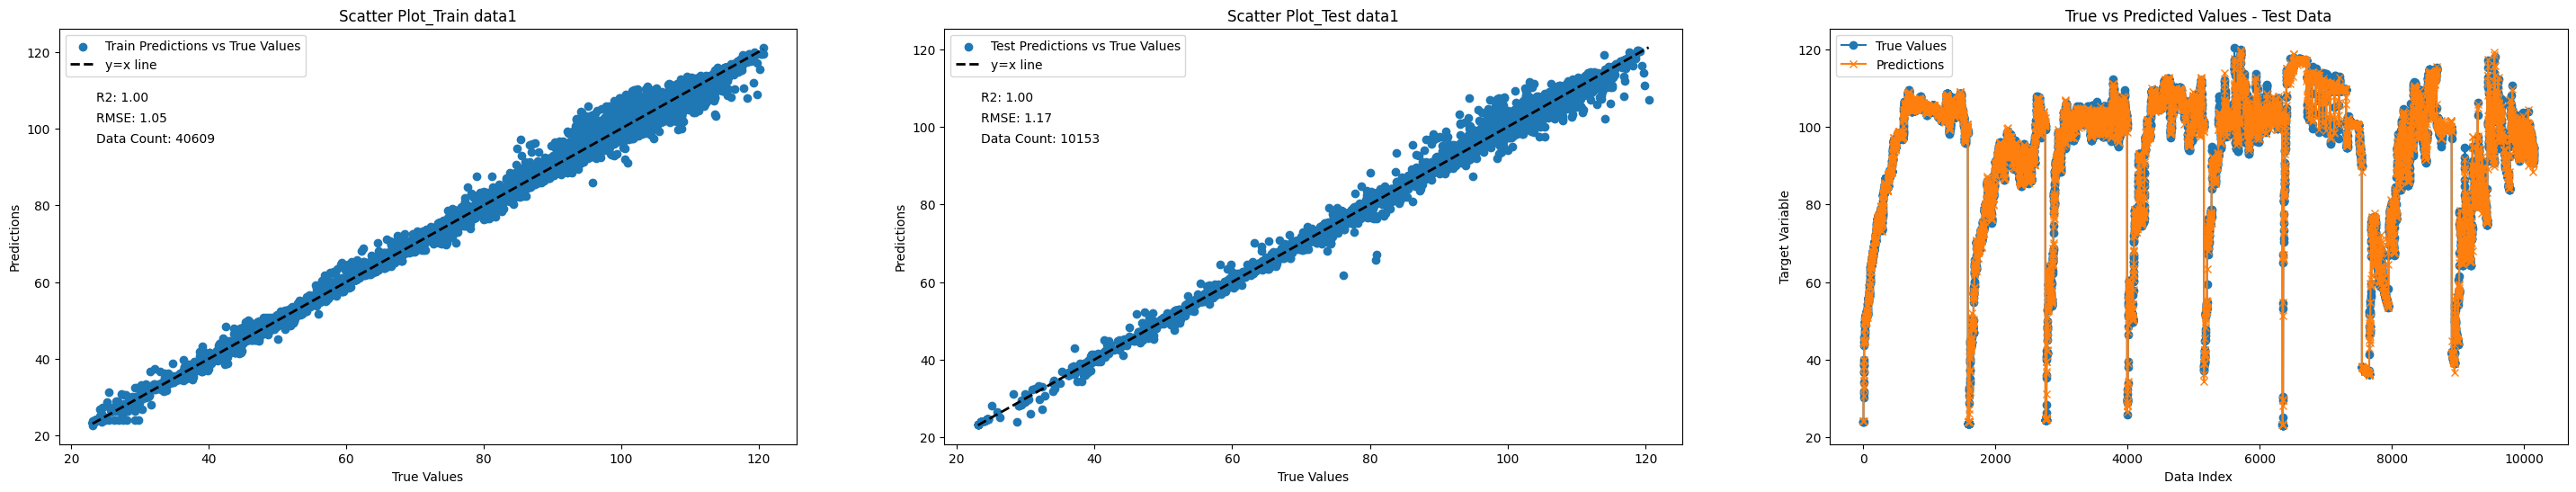

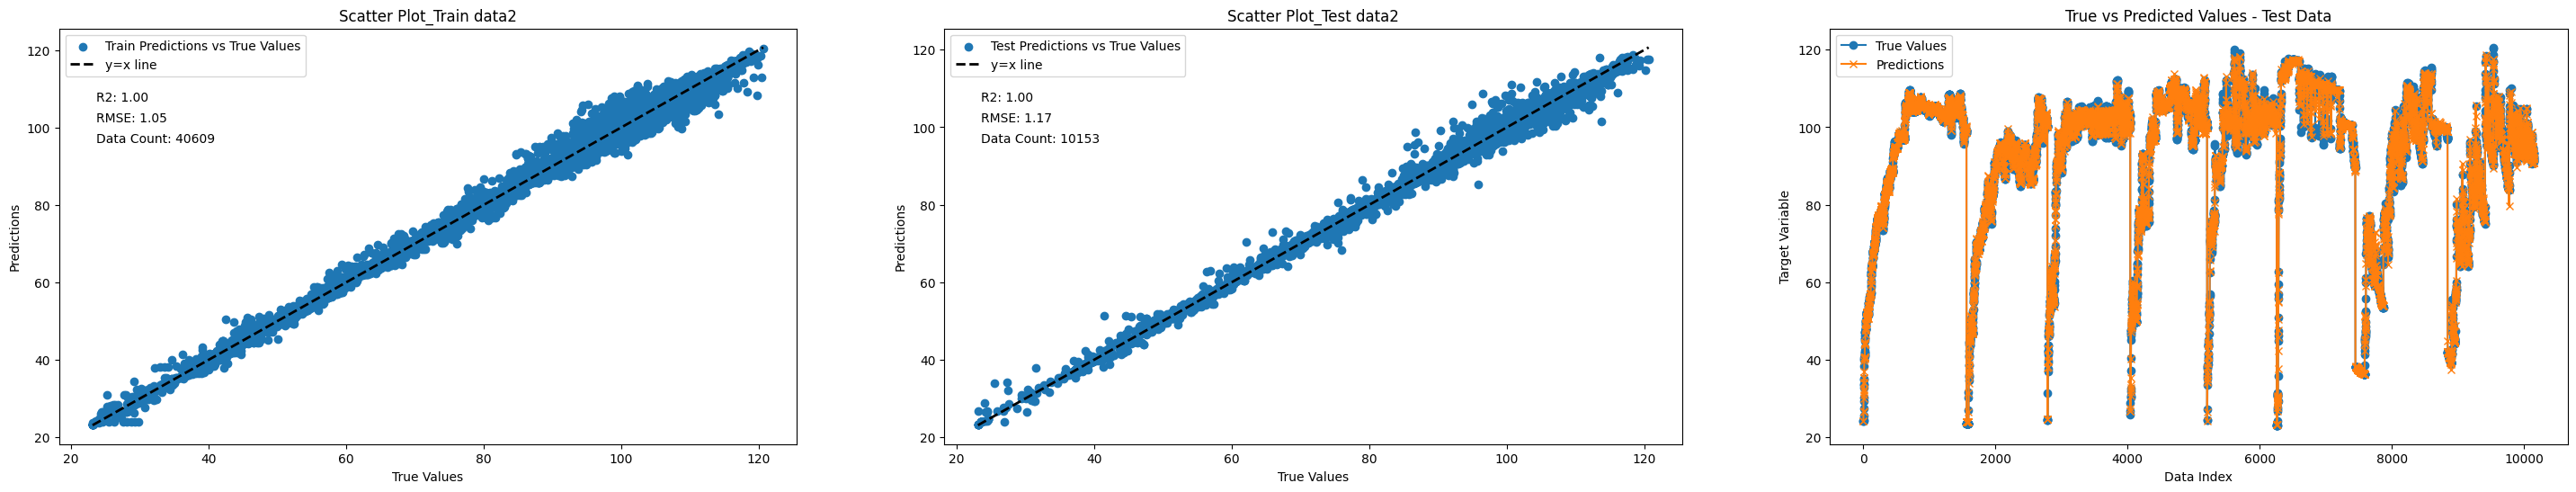

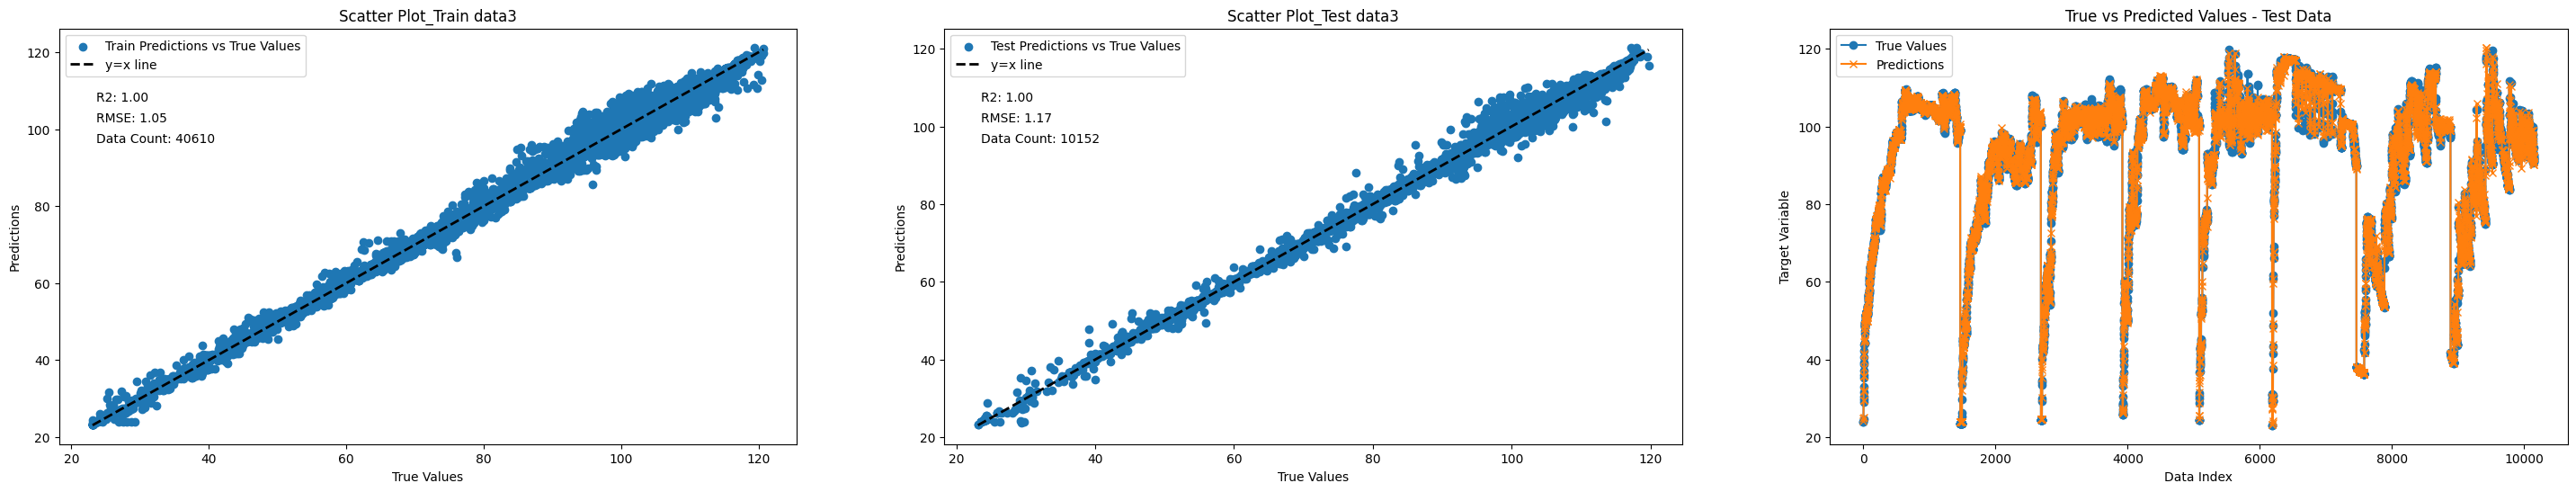

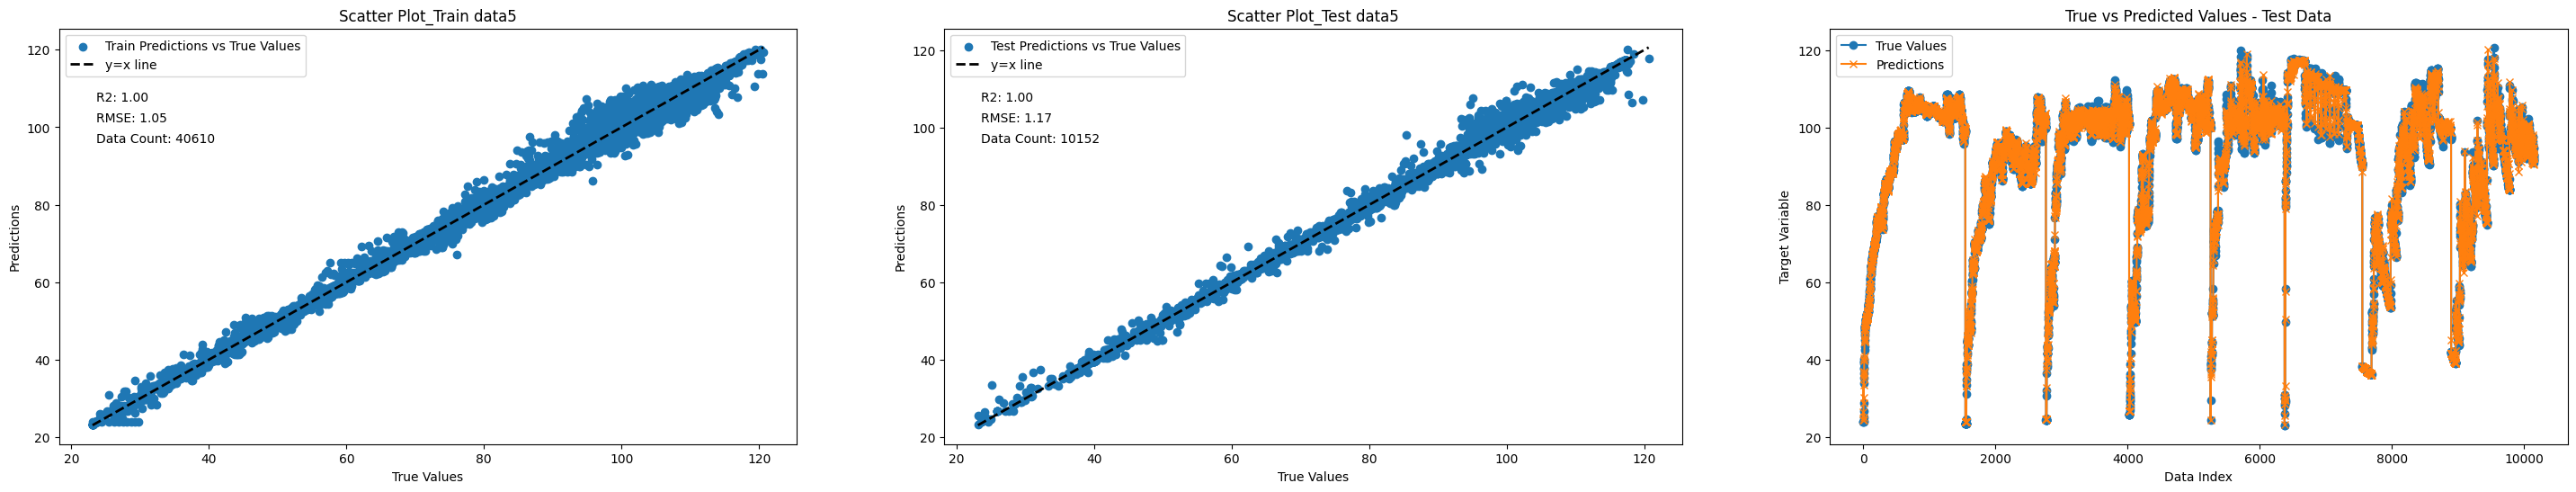

In [10]:
for i, pred in enumerate(predictions):
    y_test = pred["y_test"]
    y_pred = pred["y_pred"]
    y_train = pred["y_train"]
    y_train_pred = pred["y_train_pred"]
    
    # データ数を取得
    n_train = len(y_train)
    n_test = len(y_test)
    
    fig, axs = plt.subplots(1, 3, figsize=(36, 6))
    
    # 訓練データのScatterプロット
    axs[0].scatter(y_train, y_train_pred, label='Train Predictions vs True Values')
    axs[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2, label='y=x line')
    axs[0].set_xlabel('True Values')
    axs[0].set_ylabel('Predictions')
    axs[0].set_title(f'Scatter Plot_Train data{i+1}')
    axs[0].legend()
    axs[0].text(0.05, 0.85, f'R2: {r2_train:.2f}', transform=axs[0].transAxes, verticalalignment='top')
    axs[0].text(0.05, 0.80, f'RMSE: {rmse_train:.2f}', transform=axs[0].transAxes, verticalalignment='top')
    axs[0].text(0.05, 0.75, f'Data Count: {n_train}', transform=axs[0].transAxes, verticalalignment='top')  # データ数を表示

    # テストデータのScatterプロット
    axs[1].scatter(y_test, y_pred, label='Test Predictions vs True Values')
    axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='y=x line')
    axs[1].set_xlabel('True Values')
    axs[1].set_ylabel('Predictions')
    axs[1].set_title(f'Scatter Plot_Test data{i+1}')
    axs[1].legend()
    axs[1].text(0.05, 0.85, f'R2: {r2_test:.2f}', transform=axs[1].transAxes, verticalalignment='top')
    axs[1].text(0.05, 0.80, f'RMSE: {rmse_test:.2f}', transform=axs[1].transAxes, verticalalignment='top')
    axs[1].text(0.05, 0.75, f'Data Count: {n_test}', transform=axs[1].transAxes, verticalalignment='top')  # データ数を表示
    
    # True vs Predicted Values のプロット
    axs[2].plot(range(len(y_test)), y_test, label='True Values', marker='o')
    axs[2].plot(range(len(y_test)), y_pred, label='Predictions', marker='x')
    axs[2].set_xlabel('Data Index')
    axs[2].set_ylabel('Target Variable')
    axs[2].legend()
    axs[2].set_title('True vs Predicted Values - Test Data')
    
    plt.show()
